# Fitting a polynomial

Earlier, we used regression to find an intercept and slope (for one feature) to predict a label. The equation was:

$$f(x) = \beta_0 + \beta_1 x$$

Then, we discussed multiple regression: finding an intercept and several slopes (for several corresponding features) to predict a label. The equation was:

$$f(x_1, x_2, \dots, x_d) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d$$

A related problem is using one feature to fit a **polynomial** instead of a linear function. The equation will look like:

$$f(x) = \beta_0 + \beta_1x + \beta_2 x^2 + \beta_3x^3 + \cdots + \beta_d x^d$$

The goal is to find coefficients $\beta$ to match our observations $f(x)$ given the features $x, x^2, \ldots, x^d$.

Let's create these observations:

In [1]:
import numpy as np
np.random.seed(42)

In [2]:
def make_observations(x, sigma=0.1):
    noise = sigma * np.random.randn(len(x))
    y = 1 - np.exp(-x**2) + noise
    return y

n = 15
x = np.linspace(-2, 2, num=n)
y = make_observations(x)

Let's visualize the data:

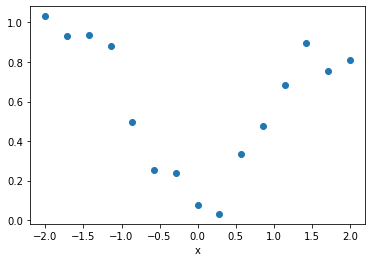

In [3]:
import pandas as pd
df = pd.DataFrame({"x": x, "y": y})
df.plot(x="x", y="y", style="o", legend=False);

**Our goal: predict the `y` values accurately given the input `x`.**

To fit this polynomial, we will need polynomial features:

In [4]:
def polynomial_features(x, max_degree=3):
    poly_df = pd.DataFrame()
    for i in range(max_degree + 1):
        poly_df[i] = x ** i
    
    return poly_df

In [5]:
d = 3

X_train = polynomial_features(x, max_degree=d)
y_train = y

print(x.min())
X_train.head()

-2.0


0         1         2         3
0  1.0 -2.000000  4.000000 -8.000000
1  1.0 -1.714286  2.938776 -5.037901
2  1.0 -1.428571  2.040816 -2.915452
3  1.0 -1.142857  1.306122 -1.492711
4  1.0 -0.857143  0.734694 -0.629738

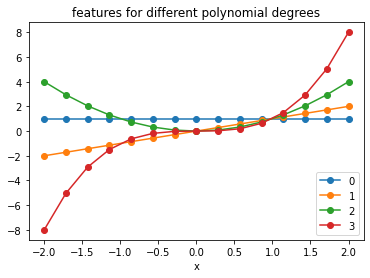

In [6]:
X_train.index = X_train[1]
ax = X_train.plot(style="o-", title="features for different polynomial degrees");
ax.set_xlabel("x");

Remember: $x, x^2, x^3$ are the features. We are trying to find $\beta_0, \ldots, \beta_3$ to make

$$f(x) = \beta_0 + \beta_1x + \beta_2 x^2 + \beta_3x^3$$

*for every $x$.*

This is the same formulation as multiple linear regression. Recall that for multiple linear regression,

$$f(x_1, x_2, \dots, x_d) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_d x_d$$

Past feature names, these formulations are identical.

In [7]:
from sklearn.linear_model import LinearRegression

# note: we don't need to use an "intercept" term because this is the same thing as using a
# polynomial of degree zero, which we have included in our list of features!
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

What did this model do? It found coefficients so that

$$y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$$

The data looks pretty quadratic; how large is $\beta_2$ relative $\beta_3$?

In [8]:
model.coef_

array([ 0.27914314, -0.03092637,  0.20295325, -0.00578903])

The best way of seeing that is by showing the predicted value over the train set:

In [9]:
import matplotlib.pyplot as plt

def fit_plot(x_train, y_train, degree=3, ax=None):
    X_train = polynomial_features(x_train, max_degree=degree)
    
    x_test = np.linspace(x_train.min(), x_train.max(), num=1000)
    X_test = polynomial_features(x_test, max_degree=degree)
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    df_test = pd.DataFrame({"x": x_test, "y_pred": y_pred})

    ax = df.plot(x="x", y="y", style="o", ax=ax)
    ax = df_test.plot(x="x", y="y_pred", ax=ax)
    ax.legend();

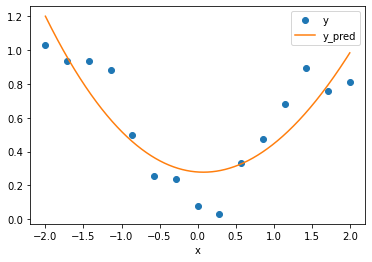

In [10]:
fit_plot(x, y, degree=3)

There's a choice here; what degree polynomial should we fit the data with? Low dimensional polynomials will be very simple, but high dimensional polynomials will fit the data better.

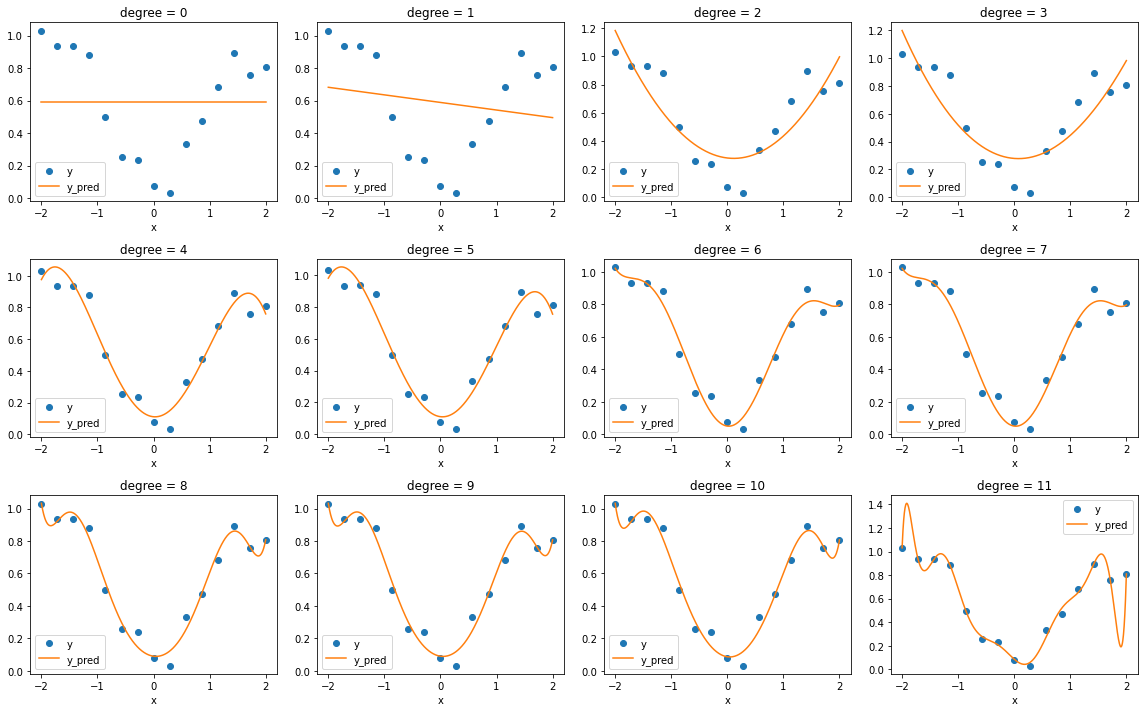

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,10))

for d, ax in enumerate(axs.flat[:]):
    fit_plot(x, y, degree=d, ax=ax)
    ax.set_title("degree = " + str(d))

fig.tight_layout()

## Model selection

We will use k-fold cross-validation to select the best degree to use

In [12]:
from sklearn.model_selection import cross_val_score

y_train = y

for d in range(10):
    X_train = polynomial_features(x, max_degree=d)
    
    model = LinearRegression(fit_intercept=False)
    
    model_scores = cross_val_score(
        model,
        X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    
    print("degree = " + str(d) + ". Mean residual sum of squares (RSS) =",
          -model_scores.mean().round(2))

degree = 0. Mean residual sum of squares (RSS) = 0.15
degree = 1. Mean residual sum of squares (RSS) = 0.31
degree = 2. Mean residual sum of squares (RSS) = 0.06
degree = 3. Mean residual sum of squares (RSS) = 1.08
degree = 4. Mean residual sum of squares (RSS) = 0.19
degree = 5. Mean residual sum of squares (RSS) = 0.71
degree = 6. Mean residual sum of squares (RSS) = 11.77
degree = 7. Mean residual sum of squares (RSS) = 27.05
degree = 8. Mean residual sum of squares (RSS) = 129.02
degree = 9. Mean residual sum of squares (RSS) = 40195.39


We can get a little more complicated and actually visualize those results...

In [13]:
from sklearn.metrics import mean_squared_error

y_train = y

scores = []
for d in range(10):
    X_train = polynomial_features(x, max_degree=d)
    model = LinearRegression(fit_intercept=False)
    model_scores = cross_val_score(
        model,
        X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    cross_val_rss = -model_scores.mean()
    
    y_train_pred = model.fit(X_train, y_train).predict(X_train)
    train_rss = mean_squared_error(y_train_pred, y_train)
    
    scores.append({
        "cross_val_rss": -model_scores.mean(),
        "train_rss": train_rss,
        "degree": d,
    })

(0.0, 1.0)

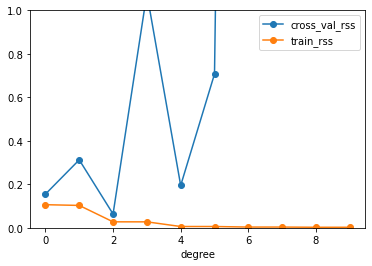

In [14]:
show = pd.DataFrame(scores)
ax = show.plot(x="degree", y=["cross_val_rss", "train_rss"], style="o-")
ax.set_ylim(0, 1)

-----------

Let's test the goal of machine learning: **to predict well on *unseen* data.** We only trained on input in a certain range and validated off that input too.

But how well does it perform on a completely new value? Let's test on unseen data, or polynomial inputs in a *slightly* broader range.

In [15]:
x_train = np.linspace(-2, 2, num=100)
y_train = make_observations(x_train)

x_test = np.linspace(-4, 4, num=100)
y_test = make_observations(x_test)

We have to make polynomial features again. Let's choose the degree `d = 2` because cross-validation *on the train data* says `d = 2` is best.

In [16]:
d = 2  # because the best value found with cross validation.

X_test = polynomial_features(x_test, max_degree=d)
X_train = polynomial_features(x_train, max_degree=d)

## Question 1a

> Fit a polynomial with degree 2 to the train data (because degree=2 is the best value found above with cross validation).
>
> Test this polynomial on the provided test data. **How well does it predict for $x$ values in [-4, -3] and [3, 4]?**
>
> * The prediction is relatively close to the testing data in [-4, -3] and [3, 4].
> * It does not predict well in [-4, -3] and [3, 4]. The prediction increases while the testing data stays flat.
> * It does not predict well in [-4, -3] and [3, 4]. The prediction decreases while the testing data stays increases.

In [ ]:
# Your code here

In [ ]:
# Define y_pred above
show = pd.DataFrame({"y_pred": y_pred, "x_test": x_test, "y_test": y_test})

ax = show.plot(x="x_test", y="y_test", style="o")
show.plot(x="x_test", y="y_pred", style="-", ax=ax)

*Gold star question:* How does this plot change as the degree is varied?

*Gold star question:* How do the answers below change when the degree `d` is changed above? How does the test score change relative to the train score *on this more general test dataset*?

## [optional] Question 1b

> What is the residual sum of squares (RSS) for the train data? Use the setup above; the degree, train data and test data will remain the same.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# Your code here

## [optional] Question 1c
> What is the residual sum of squares (RSS) for the test data? Use the setup above; the degree, train data and test data will remain the same.

In [ ]:
from sklearn.metrics import mean_squared_error

# Your code here